In [191]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import normaltest

In [192]:
data = anndata.read_h5ad('data/Group_6.h5ad')

In [193]:
# data.X.toarray()

In [194]:
# We will record the original cell type counts to make sure QC doesn't disproportionately remove any cell types
original_cell_type_counts = data.obs["cell-types"].value_counts()

We don't want to include genes that are expressed in very few cells, as they are unlikely to provide useful information for downstream analysis.
We can start with a general look at how many cells express each gene.

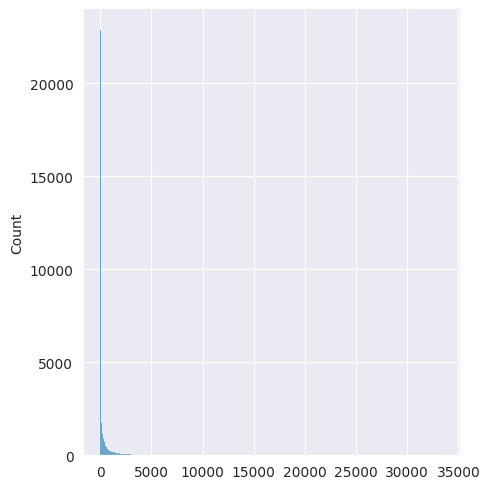

In [195]:
cells_per_gene = (data.X.toarray() > 0).sum(axis=0)
sns.displot(cells_per_gene)
plt.show()

To get a better idea of how many genes would be removed at different thresholds, we can plot the cumulative number of genes that would be removed as we increase the minimum cell threshold.

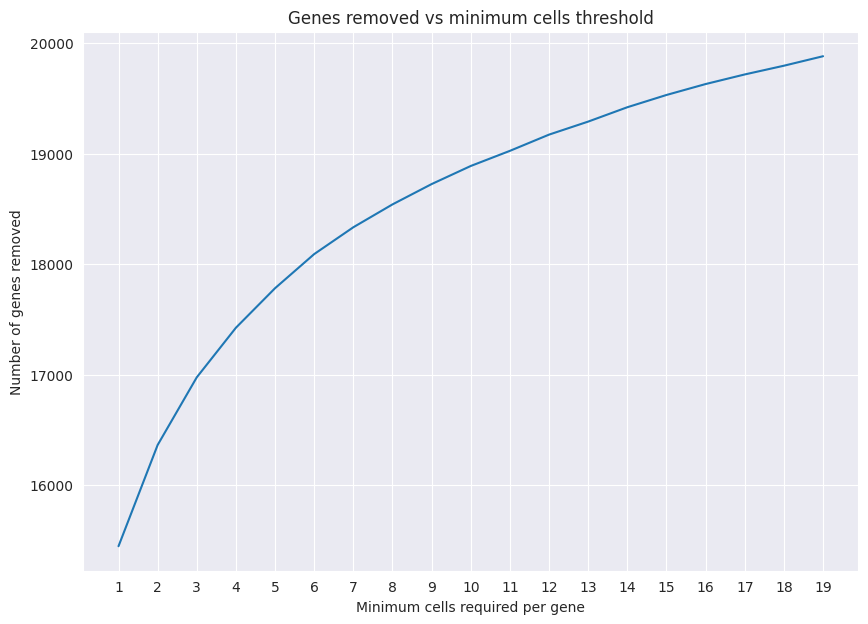

In [196]:
cumsum = np.cumsum(np.bincount(cells_per_gene))

removed = []
for m in range(1, 20):
    removed.append(int(cumsum[m]))

plt.figure(figsize=(10, 7))
plt.plot(range(1, 20), removed)
plt.xlabel("Minimum cells required per gene")
plt.ylabel("Number of genes removed")
plt.title("Genes removed vs minimum cells threshold")
plt.xticks(range(1,20))
plt.grid(True)
plt.show()

The inflection point seems to be around 3-5 cells, so we will err on the side of caution and filter out genes that are expressed in fewer than 3 cells. Lets check how many genes that removes.

In [197]:
before = data.shape[1]
sc.pp.filter_genes(data, min_cells=3)
print("Genes removed:", before - data.shape[1])

Genes removed: 16362


Next we can look at the distribution of how many genes are detected per cell to identify potential outliers.

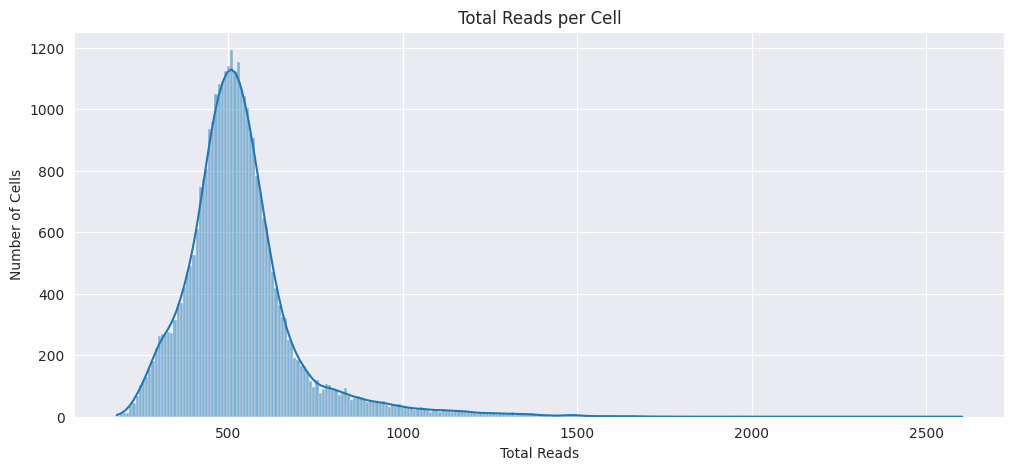

In [198]:
genes_per_cell = (data.X.toarray() > 0).sum(axis=1)

plt.figure(figsize=(12, 5))
sns.histplot(genes_per_cell, kde=True)
plt.title('Total Reads per Cell')
plt.xlabel('Total Reads')
plt.ylabel('Number of Cells')
plt.show()

Let's use the median absolute deviation (MAD) to identify outlier genes that are expressed in an unusually high or low number of cells.

Percent of cells removed by filtering: 11.457214464733257


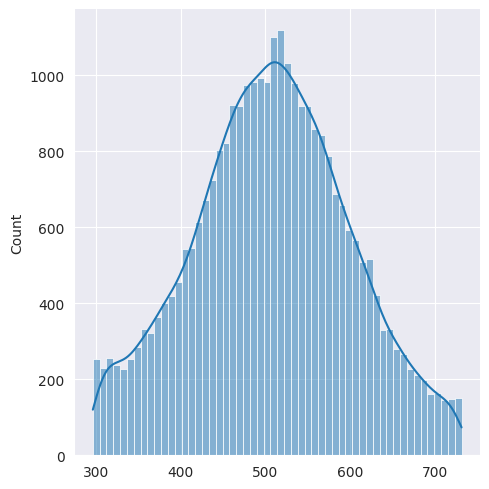

In [199]:
median = pd.Series(genes_per_cell).median()
mad = pd.Series((genes_per_cell - median)).abs().median()
upper_bound = median + 3 * mad
lower_bound = median - 3 * mad

data_filtered = data[genes_per_cell > lower_bound, :]
data_filtered = data_filtered[(data_filtered.X.toarray() > 0).sum(axis=1) < upper_bound, :]
print("Percent of cells removed by filtering:", 100 * (1 - data_filtered.shape[0] / data.shape[0]))
sns.displot((data_filtered.X.toarray() > 0).sum(axis=1), kde=True)
plt.show()

We are left with a cleaner dataset without the long tail of outlier cells which would likely skew downstream analyses, while only removing about 11% of the cells.

/tmp/ipykernel_19622/4100890292.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)


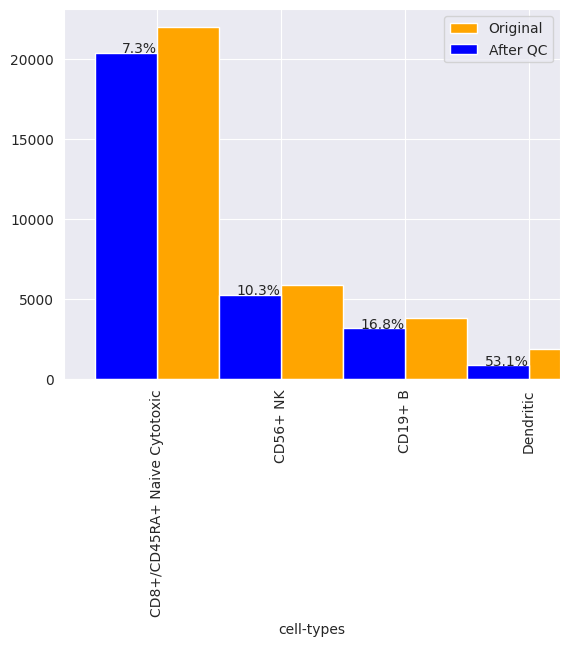

In [200]:
original_cell_type_counts.plot(kind='bar', color='orange', label='Original', position=0)
after_qc_counts = data_filtered.obs["cell-types"].value_counts()
after_qc_counts.plot(kind='bar', color='blue', label='After QC', position=1)

percent_drop = 100 * (original_cell_type_counts - after_qc_counts) / original_cell_type_counts
for i, v in enumerate(percent_drop):
    plt.text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)

plt.legend()
plt.show()

There is a clear bias against the Dendritic cells, which had a much higher percentage of cells removed compared to the other cell types. We can investigate this further by plotting the distribution of genes detected per cell for each cell type.

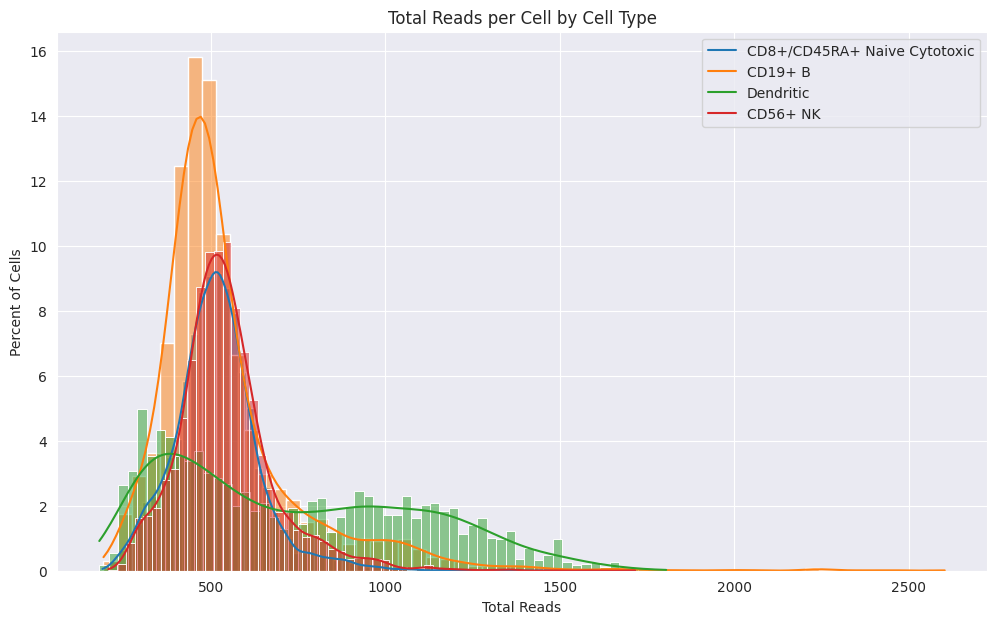

In [201]:
cell_types = data.obs["cell-types"].unique()

plt.figure(figsize=(12, 7))
plt.title('Total Reads per Cell by Cell Type')
plt.xlabel('Total Reads')
plt.ylabel('Percent of Cells')

for cell_type in cell_types:
    cell_type_indexes = data.obs[data.obs["cell-types"] == cell_type].index
    genes_per_cell = (data[cell_type_indexes].X.toarray() > 0).sum(axis=1)

    sns.histplot(genes_per_cell, kde=True, label=cell_type, stat="percent", bins=60)

plt.legend([ct for ct in cell_types])
plt.show()

There is a clear distrbution difference in the Dendritic cells compared to the other cell types. To account for this, we can apply cell type specific QC thresholds based on the MAD for each cell type individually.

CD8+/CD45RA+ Naive Cytotoxic lower bound: 311.0 upper bound: 713.0
CD19+ B lower bound: 263.0 upper bound: 719.0
Dendritic lower bound: -200.0 upper bound: 1516.0
CD56+ NK lower bound: 321.0 upper bound: 735.0
Percent of cells removed by filtering: 10.180212435851532


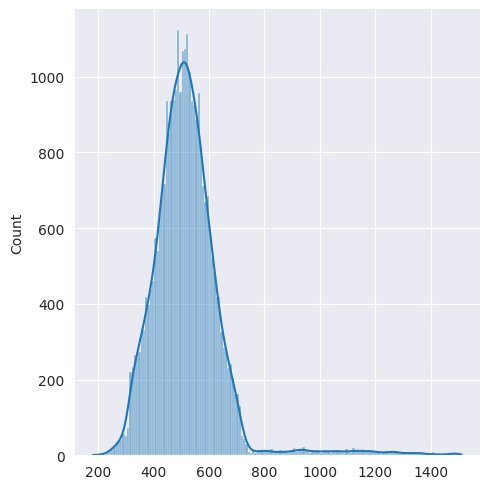

In [202]:
filtered_data = []
for ct in cell_types:
    genes_per_cell = (data[data.obs["cell-types"] == ct].X.toarray() > 0).sum(axis=1)
    median = pd.Series(genes_per_cell).median()
    mad = pd.Series((genes_per_cell - median)).abs().median()
    upper_bound = median + 3 * mad
    lower_bound = median - 3 * mad
    print(ct, "lower bound:", lower_bound, "upper bound:", upper_bound)

    ct_filtered = data[data.obs["cell-types"] == ct][(genes_per_cell > lower_bound) & (genes_per_cell < upper_bound), :]
    filtered_data.append(ct_filtered)

data_filtered_per_cell = anndata.concat(filtered_data)
print("Percent of cells removed by filtering:", 100 * (1 - data_filtered_per_cell.shape[0] / data.shape[0]))

sns.displot((data_filtered_per_cell.X.toarray() > 0).sum(axis=1), kde=True)
plt.show()

/tmp/ipykernel_19622/345978520.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)
/tmp/ipykernel_19622/345978520.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)


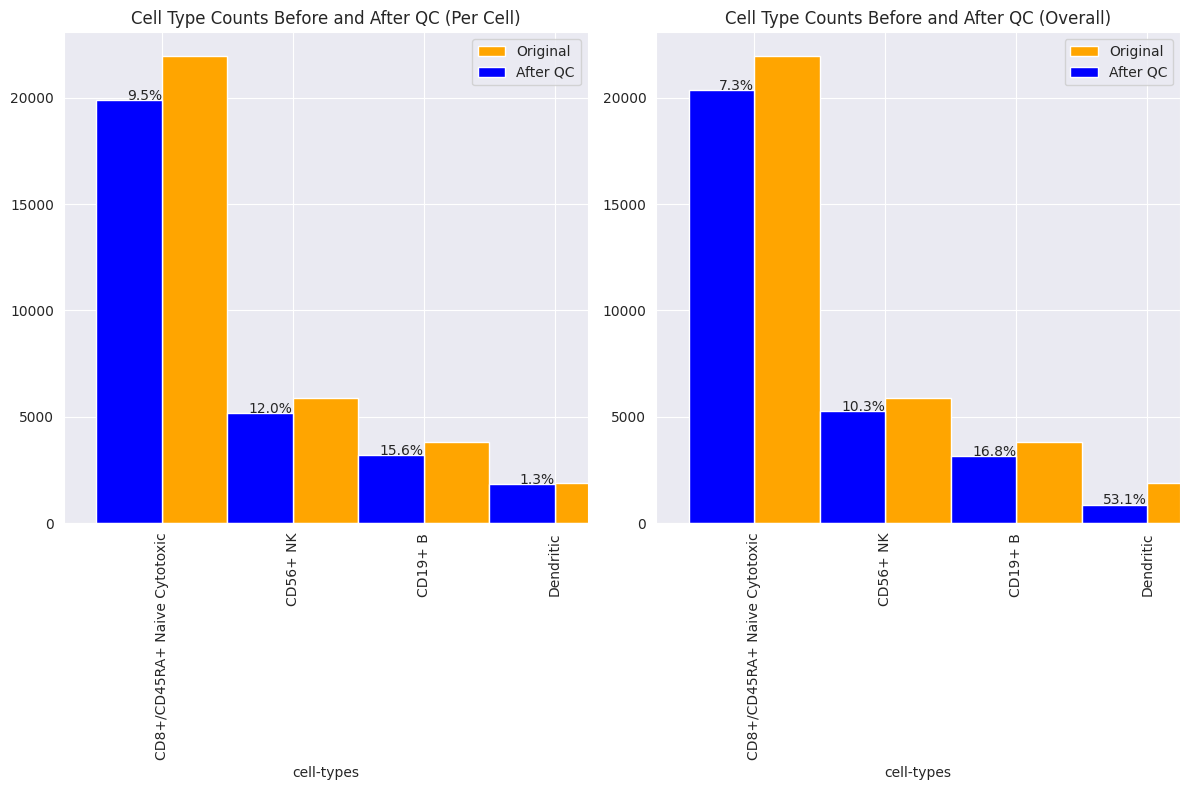

In [203]:

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# First subplot
original_cell_type_counts.plot(kind='bar', color='orange', label='Original', ax=axes[0], position=0)
after_qc_counts = data_filtered_per_cell.obs["cell-types"].value_counts()
after_qc_counts.plot(kind='bar', color='blue', label='After QC', ax=axes[0], position=1)

percent_drop = 100 * (original_cell_type_counts - after_qc_counts) / original_cell_type_counts
for i, v in enumerate(percent_drop):
    axes[0].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)

axes[0].legend()
axes[0].set_title("Cell Type Counts Before and After QC (Per Cell)")

# Second subplot
original_cell_type_counts.plot(kind='bar', color='orange', label='Original', ax=axes[1], position=0)
after_qc_counts = data_filtered.obs["cell-types"].value_counts()
after_qc_counts.plot(kind='bar', color='blue', label='After QC', ax=axes[1], position=1)

percent_drop = 100 * (original_cell_type_counts - after_qc_counts) / original_cell_type_counts
for i, v in enumerate(percent_drop):
    axes[1].text(i, after_qc_counts[i] + 0.5, f"{v:.1f}%", ha='right', fontsize=10)

axes[1].legend()
axes[1].set_title("Cell Type Counts Before and After QC (Overall)")

plt.tight_layout()
plt.show()

The filtering based on cell type specific thresholds does a much better job of preserving the original cell type proportions, while still removing a similar overall percentage of cells. This should lead to more balanced downstream analyses.